# kuzushiji-MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

--2024-08-30 03:01:44--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz’

kmnist-train-imgs.n 100%[===================>]  17.53M  1.56MB/s    in 16s     

2024-08-30 03:02:00 (1.12 MB/s) - ‘kmnist-train-imgs.npz’ saved [18384171/18384171]

--2024-08-30 03:02:00--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz’

kmnist-train-labels 100%[===================>]  29.00K  --.-KB/s    in 0.1s    

2024-08-30 03:02:00 (198 KB/s) - ‘kmnist-train-labels.npz’ saved [29700/29

In [ ]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz')
X_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[0].shape, X_test[0].shape

((28, 28), (28, 28))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

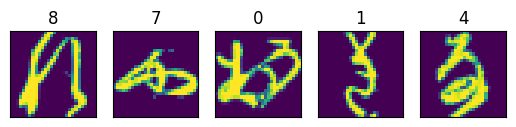

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0337       0.8302        0.5790  2.5865
      2        0.6256       0.8645        0.4523  2.3818
      3        0.5348       0.8812        0.3943  2.4028
      4        0.4823       0.8927        0.3585  2.4129
      5        0.4499       0.9004        0.3342  2.6590
      6        0.4299       0.9052        0.3167  2.4076
      7        0.4060       0.9107        0.3029  1.8485
      8        0.3935       0.9140        0.2948  1.9159
      9        0.3817       0.9160        0.2847  1.8603
     10        0.3695       0.9181        0.2743  1.8388
     11        0.3589       0.9194        0.2704  1.7130
     12        0.3514       0.9207        0.2642  2.0935
     13        0.3429       0.9227        0.2568  1.9588
     14        0.3385       0.9228        0.2547  1.4492
     15        0.3314       0.9241        0.2527  1.4386
     16        0.3236       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.8452

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4085       0.7895        0.7249  1.9600
      2        0.8375       0.8357        0.5366  1.3609
      3        0.6827       0.8620        0.4469  1.3573
      4        0.5879       0.8786        0.3948  1.3752
      5        0.5127       0.8898        0.3542  1.3824
      6        0.4609       0.9008        0.3239  1.3750
      7        0.4206       0.9091        0.3020  1.3745
      8        0.3849       0.9119        0.2919  1.3578
      9        0.3550       0.9157        0.2796  2.0877
     10        0.3368       0.9190        0.2681  1.7810
     11        0.3124       0.9211        0.2616  1.3916
     12        0.3001       0.9244        0.2570  1.3642
     13        0.2868       0.9263        0.2521  1.3443
     14        0.2700       0.9263        0.2502  1.3470
     15        0.2605       0.9269        0.2482  1.3260
     16        0.2494       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.8519

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2790       0.8078        0.6319  1.2788
      2        0.6766       0.8563        0.4676  1.2431
      3        0.5463       0.8732        0.4072  1.2652
      4        0.4792       0.8888        0.3653  1.2955
      5        0.4297       0.8957        0.3427  1.2839
      6        0.3919       0.9018        0.3238  1.4128
      7        0.3662       0.9052        0.3083  1.9521
      8        0.3445       0.9092        0.3016  1.6225
      9        0.3220       0.9110        0.2945  1.2321
     10        0.3078       0.9132        0.2873  1.2475
     11        0.2943       0.9169        0.2798  1.2626
     12        0.2842       0.9166        0.2794  1.2530
     13        0.2737       0.9177        0.2779  1.2566
     14        0.2637       0.9177        0.2800  1.2526
     15        0.2533       0.9190        0.2744  1.7949
     16        0.2484       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.8285

In [ ]:
error_mask = y_pred != y_test

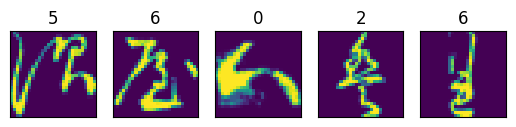

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2891       0.8027        0.6585  1.3429
      2        0.7299       0.8502        0.4916  1.3352
      3        0.5893       0.8754        0.4094  1.3347
      4        0.5135       0.8855        0.3734  1.4977
      5        0.4538       0.8973        0.3388  2.0255
      6        0.4169       0.9054        0.3192  1.5138
      7        0.3872       0.9110        0.3015  1.3145
      8        0.3580       0.9131        0.2918  1.3002
      9        0.3372       0.9140        0.2809  1.3036
     10        0.3177       0.9187        0.2729  1.3068
     11        0.3057       0.9200        0.2657  1.3594
     12        0.2904       0.9212        0.2653  1.3125
     13        0.2779       0.9243        0.2588  1.4834
     14        0.2674       0.9244        0.2541  2.0644
     15        0.2528       0.9251        0.2554  1.5392
     16        0.2490       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.8416

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2978       0.1767        2.2615  1.6731
      2        1.8910       0.4856        1.4441  2.4307
      3        1.4538       0.6247        1.1228  3.1495
      4        1.2285       0.7323        0.8917  1.6506
      5        1.0768       0.7827        0.7650  1.3885
      6        0.9658       0.8158        0.6702  1.3467
      7        0.9010       0.8277        0.6281  1.3171
      8        0.8427       0.8332        0.6034  1.3493
      9        0.8039       0.8503        0.5632  1.3560
     10        0.7663       0.8469        0.5844  1.4474
     11        0.7448       0.8440        0.5650  2.0352
     12        0.7250       0.8470        0.5682  1.7057
     13        0.7056       0.8636        0.5456  1.3619
     14        0.6709       0.8615        0.5367  1.2922
     15        0.6497       0.8603        0.5345  1.3356
     16        0.6321       0.8

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.7503

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = np.abs(corr.cpu().detach().numpy())
      if np.isnan(corr):
        corr = 0
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.5643478
correlation between net1 and net3: 0.5769708
correlation between net1 and net4: 0.59022254
correlation between net1 and net5: 0.5230021
correlation between net2 and net3: 0.6126397
correlation between net2 and net4: 0.6199032
correlation between net2 and net5: 0.52668005
correlation between net3 and net4: 0.67054975
correlation between net3 and net5: 0.5436354
correlation between net4 and net5: 0.509585


# Convolutional Network


In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7671       0.9287        0.2462  45.6223
      2        0.4076       0.9471        0.1737  44.8325
      3        0.3285       0.9558        0.1488  54.9283
      4        0.2964       0.9621        0.1292  45.2156
      5        0.2717       0.9663        0.1129  46.7353
      6        0.2481       0.9690        0.1033  45.1683
      7        0.2374       0.9686        0.1042  46.9966
      8        0.2240       0.9709        0.0990  45.0433
      9        0.2107       0.9734        0.0909  45.4089
     10        0.2086       0.9740        0.0859  45.6253


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9263

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.9245271
correlation between net2 and cnn: 0.9171139
correlation between net3 and cnn: 0.9486944
correlation between net4 and cnn: 0.9421186
correlation between net5 and cnn: 0.54904926
